# Numerik III, Notebook 5: Adaptive Schrittweitensteuerung

Dieses Notebook behandelt 
+ das Konzept einer adaptiven Schrittweitensteuerung 
+ Eingebettete Runge-Kutta-Verfahren 
+ Eine Projektaufgabe zur Implementierung und zum Test eines eingebetteten Runte-Kutta-Verfahrens mit adaptiver Schrittweitensteuerung.


**Ziel:** Mit möglichst wenig Zeitschritten soll eine vorgegebene Genauigkeit der numerischen Lösung erreicht werden. 

**Idee:** Wähle unterschiedliche problemangepasste Zeitschritten $h_k$ während der Berechnung. Da die Lösung $y(t)$ nicht vorher bekannt ist, müssen geeignete Schrittweiten während der Berechnung gewählt werden.


(Effizienz-Bewertung eines Diskretisierungsverfahrens eines numerischen Lösers für AWPe: Wieviele Funktionsauswertungen der rechten Seite sind für eine vorgebene Fehlertoleranz notwendig. Dies kann an AWPen evaluiert werden, deren Lösung analytisch berechenbar ist. Im Allgemeinen ist dieses Maß für die Effizienz nur empirisch durch numerische Experimente bestimmbar. Allerdings führt die mathematische Analyse möglicher Diskretisierungsverfahren zur Konstruktion geeigneter Verfahren.) 

## Populäre Strategie (für ESV)

1. In jedem Schritt $y^{j} \longrightarrow y^{j+1}$ wird *adaptiv* eine geeignete Schrittweite $h_j = t_{j+1} - t_j$ gewählt.

2. Wir versuchen, den lokalen Fehler $\delta_j:= \delta(t_j, h_j)$ zu kontrollieren

3. These: *Ein gleichverteilter Fehler ergibt ein optimales Gitter* (das ist nicht beweisbar, und stimmt auch nicht immer). D.h. wir geben eine Toleranz $tol$ vor, und fordern, dass in jedem Zeitschritt der lokale Fehler kleiner als diese Toleranz ist (bei Systemen ist der Fehler vektorwertig, daher wird hier noch irgendeine Norm auf $\mathbb{R}^n$ genommen):

$$
  \| \delta(t_j, h_j \| \leq tol, \qquad \text{idealerweise }\, \| \delta(t_j, h_j \| \approx tol
$$

4. Leider ist $\delta_j := \delta(t_j, h_j)$ nicht bekannt, so dass wir nicht ohne weiteres aus der obigen Ungleichung ein geeignetes $h_j$ bestimmen können. Wir benötigen daher einen berechenbaren Fehlerschätzer $s_j \approx \delta_j$. Dieser kann im Allgemeinen erst nach der Bestimmung von $y^{j+1}$ berechnet werden. Um die Berechnung eines solchen Fehlerschätzers kümmern wir uns später. Falls also $s_j$ ein guter Fehlerschäzter ist, dann hätten wir gerne, dass

$$
  \| s_j \| \leq tol, \qquad \text{idealerweise }\, \| s_j \| \approx tol.
$$

5. Wir berechnen jetzt *im Nachhinein*, was die *optimale Schrittweite* gewesen wäre. Wir bestimmen also zunächst den Wert $\| s_j \|$. Wir dagehen von aus, dass unser Diskretisierungverfahren die Konsistenzordnung $p$ hat. Dann hat der lokale Fehler $\delta(t, h)$ die Fehlerordnung $p+1$ und damit gilt das auch für den Fehlerschätzer $s_j$:

$$
\| s_j \| \approx \| \delta(t_j, h_j) \| \leq c h_j ^{p+1}
$$

Die einzige Unbekannte ist hier die Konstante $c$. 
Wir setzen jetzt in der obigen Gleichung das $\leq$ durch ein $\approx$ (das ist eine Annahme an den Fehlerschätzer bzw. an das Diskretisierungsverfahren !) und berechnen eine Schrittweite $h_\mathrm{opt}$, so dass wir mit dieser Schrittweite genau die geforderte Toleranz $tol$ erreicht hätten. Zur Sicherheit fordern wir mit einen Faktor $0< \rho < 1$ (üblich ist z.B.  $\rho = 0.9$)

$$
\rho \, tol = c h_\mathrm{opt}^{p+1}, \qquad \text{mit} \quad c =  \frac{ \| s_j \|}{h_j ^{p+1}}.
$$

Auflösen nach $h_\mathrm{opt}$ ergibt dann schließlich die gesuchte Formel für einen (unter den zahlreichen getroffenen Annahmen) optimalen Schrittweitenvorschlag (nicht zu klein, nicht zu groß)
    
$$
  \boxed{  h_\mathrm{opt} = h_j \Big( \frac{\rho \, tol}{\| s_j \|} \Big)^{\frac{1}{p+1}} }
$$

6. Falls im Schritt $y^{j} \rightarrow y^{j+1}$ die geforderte Toleranz $tol$ nicht erreicht wurde, dann wird die Berechnung $y^{j+1}$ mit dem neuen Zeitschritt $h_j := h_\mathrm{opt}$ wiederholt. Falls die Toleranz erreicht wurde, dann wird der nächste Zeitschritt mit der SChrittweite $h_{j+1} := h_\mathrm{opt}$ ausgeführt

7. Es werden im Allgemeinen noch eine minimal erlaubte Schrittweite $h_\mathrm{min}$ und eine maximal erlaubte Schrittweite $h_\mathrm{max}$ festgelegt. Wird die minimale Schrittweite unterschritten, so soll das Verfahren abbrechen -- die Rechenzeit würde dann zu groß werden. Außerdem wird ein maximaler Hochschaltfaktor $q > 1$ festgelegt: Die Schrittweite darf sich in einem Schritt nur maximal um einen Faktor $q$ vergrößern. Dies ist zum Beispiel deswegen notwendig, weil in einem Schritt der Fehler (zufällig oder tatsächlich) fast Null sein kann. Dann darf das Verfahren aber nicht im nächsten Zeitschritt zu weit fortschreiten, z.B. über die nächste komplizierte Stelle.

Damit ergibt sich der folgende 
**Adaptiver Grundalgorithmus:**   

   
-------------------------------------------------------------------------------------------------
\begin{align}
& \text{Input: }  \text{AWP} (f, \, y^0, \, t_0, \, t_f); \\
& \qquad  \text{ Parameter } tol, \, \rho, \, q, \, h_\mathrm{max}, \, h_\mathrm{min}  \\
& \\
& j = 0 &\\
& h_0 = h_\mathrm{max} \\
& \textbf{while} \,\,  t_j < t_f \\
& \qquad    t = t_j + h_j \\
& \qquad    y = y^j + h_j \phi_f(t_j, y^j, h_j) \\
& \qquad \text{berechne Fehlerschätzung } \| s_j \| \\
& \qquad  h = \min \{ q h_j, h_\mathrm{max},  h_j \Big( \frac{\rho \, tol}{\| s_j \|} \Big)^{\frac{1}{p+1}} \} \\
& \qquad \textbf{if} \,\,  h < h_{min} \\
& \qquad \qquad \textbf{break} \\
& \\
& \qquad \textbf{if} \, \, ( \| s_j \| < tol ) \\
& \qquad \qquad t_{j+1} = t \\
& \qquad \qquad y^{j+1} = y \\
& \qquad \qquad h_{j+1} = \min (h, t_f - t_{j+1}) \\
& \qquad \qquad j = j+1 \\
& \qquad \textbf{else} \\
& \qquad \qquad h_j = h \\
\end{align}

------------------------------------------------------------------------------------------------------------------




## Fehlerschätzung mit eingebetteten Runge-Kutta-Verfahren

Für eine Fehlerschätzung werden zwei Verfahren unterschiedlicher Genauigkeit verwendet:

\begin{align*}
    y^{j+1} = y^j + h \, \Phi_f(t_j, y^j, h) \\
    \hat{y}^{j+1} = y^j + h \, \hat{\Phi}_f(t_j, y^j, h)
\end{align*}

Dann ergibt die Differenz der beiden Approximationen $y^{j+1} $ und $ \hat{y}^{j+1}$ unter geeigneten Voraussetzungen einen guten Fehlerschätzer

$$
    \boxed{
    s_j := y^{j+1}-  \hat{y}^{j+1} = \hat{\delta}_j - \delta_j
    }
$$
(für das ungenauere Verfahren).


Einfache Konstruktion zweier Verfahren unterschiedlicher Genauigkeit: $\Phi$ hat Fehlerordnung $p$, $\hat{\Phi}$ hat Fehlerordnung $p-1$. Um möglichst wenig zusätzliche Rechenaufwand für die Fehlerschätzung zu haben, werden sogenannte eingebettete Runge-Kutta-Verfahren konstruiert. Die beiden Verfahren unterscheiden sich nur durch eine weitere Stufe im Butcher-Tableau.



### Beispiel: Runge-Kutta 4(3) 

Zum klassischen Runge-Kutta-Verfahren wird eine weitere Stufe hinzugefügt (ein $k_5$), so dass das zweite resultierende fünfstufige Verfahren die Fehlerordnung $q=3$ hat (also echt ungenauer ist !). Außerdem wird das Verfahren so konstruiert, dass die 5-te Stufe (also $k_5$) denselben Wert wie $k_1$ im nächsten Zeitschritt hat (FSAL: first same as last), so dass pro Zeitschritt effektiv nur vier Funktionsauswertungen notwendig sind. Das zugehörige Butchertableau sieht wie folgt aus:

$$
\begin{matrix}
k_1: \qquad &  0 & | & &  & & & \\
k_2: \qquad & 1/2 & | & 1/2 & & & & \\
k_3: \qquad &  1/2 & | & 0 & 1/2 & &  & \\
k_4: \qquad &  1   & | & 0 & 0 & 1 & &  \\
k_5: \qquad &  1   & |  & 1/6 & 1/3 & 1/3 & 1/6   \\
\hline 
 b : \qquad & & | & 1/6 & 1/3 & 1/3 & 1/6 & 0 \\
 \hat{b}: \qquad & & | & 1/6 & 1/3 & 1/3 & 0 & 1/6 
 \end{matrix} 
 $$
 
mit 

\begin{align*}
  \Phi_f &= \sum_{l=0}^{4} b_l k_l = \tfrac{1}{6}k_1 + \tfrac{1}{3} k_2 + \tfrac{1}{3} k_3 + \tfrac{1}{6} k_4 \\
    \hat{\Phi}_f &=\sum_{l=0}^{5} \hat{b}_l k_l = \tfrac{1}{6}k_1 + \tfrac{1}{3} k_2 + \tfrac{1}{3} k_3 + \tfrac{1}{6} k_5
\end{align*}

Damit ergibt sich insbesondere

$$
s_j = y^{j+1}-  \hat{y}^{j+1} = h \Phi_f - h \hat{\Phi} = \frac{h}{6}(k_4 - k_5)
$$

Außerdem ist $k_1^{j+1} = k_5^j$.

Man beachte, dass der Fehler des ungenaueren Verfahrens ($q=3$) geschätzt wird. Dies muss bei der Wahl des Exponenten zur Bestimmung eines optimalen Schrittweitenvorschlags beachtet werden (siehe oben Grundalgorithmus). Trotzdem wird dann immer das bessere Ergebnis $y^{j+1}$ verwendet, nicht $\hat{y}^{j+1}$.

### Eingebettete RK-Methode von Dormand und Prince 

siehe [Wikipedia](https://en.wikipedia.org/wiki/Dormand-Prince_method) oder auch
[Paper von Dormand and Prince](https://doi.org/10.1016/0771-050X(80)90013-3)

Dieses Verfahren wird wird in zahlreichen Softwarepaketen als *Default*-Löser verwendet.
Es ist ein Runge-Kutta 5(4) Verfahren mit sieben Stufen ( $m=7$), effektiv 6-stufig da FSAL.  Es gibt auch noch ein 13-Stufiges Verfahren vom Typ RK 8(7).


## Projektaufgabe

#### Aufgabe 1:(10 Punkte)
Erweitern Sie das klassische Runge-Kutta-Verfahren um eine adaptive Schrittweitensteuerung. Benutzen Sie dazu das 
	eingebettete RK-Verfahren vom Typ 4(3) mit dem oben angegebenen Butcher-Schema

+ Implementieren Sie das eingebettete Runge-Kutta-Verfahren RK 4(3) mit adaptischer Schrittweitensteuerung als Pythonfunktion mit der Signatur wie in der Code-Vorlage `rungekutta_43` in einem Python-Modul

+ Geben sie auch die Anzahl der benötigten Funktionsauswertungen zurück. Die Toleranz soll als Paramter übergeben werden können. Sie können auch die anderen Parameterwerte übergeben. Default-Werte sind in der Code-Vorlage.

+ Testen Sie (in dem Python-Modul) die Funktion mit einem skalaren und einem vektorwertigen Problem auf korrekte Syntax und Funktionsweite (siehe auch Code-Vorlage.

#### Aufgabe 2: (3 mal 5 Punkte)
Auswertung in einem Jupyter Notebook mit geeigneten Grafiken und Erläuterungen.

+ Testen Sie die Konvergenz des Implementierten Verfahrens mit einem (nichtlinearen) AWP, bei dem eine exakte Lösung bekannt ist. Geht der globaler Fehler (fast) gegen Null bei immer kleinerer Toleranz? Tragen Sie den globalen Fehler (logarithmisch) gegen die Anzahl der benötigten Funktionsauswertungen auf. 

+ Testen Sie das Verhalten bei einem AWP mit einer Singularität und bei einem AWP, dessen Lösung in endlicher Zeit gegen $\infty$ geht. Benutzen Sie dazu Beispiel 1 und Beispiel 2 unten. Berechnen Sie auch in beiden Fällen die exakte Lösung mit der Methode der Trennung der Variablen. Tragen Sie die (adaptive Schrittweite) $h$ über die Zeit auf. (Tipp: Sie erhalten die verwendeten Schritten als Differenzen der diskreten Zeitpunkte: `hk = tk[1:] - tk[0:-1]` .

+ Genauigkeits- und Performance-Test beim restringierten Dreikörperproblem (Ahrenstorf-Orbit). Betrachten Sie das AWP in Beispiel 3: Können Sie mit dem adaptiven Verfahren eine Genauigkeit der Lösung (Abstand von Start- und Endpunkt der periodischen Lösung) bis auf einen Kilometer oder sogar bis auf einen Meter erreichen? Wie verhält sich im Vergleich dazu das explizite Euler-Verfahren oder das (nicht adaptive) klassische Runge-Kutta-Verfahren ? Tragen Sie auch hier die adaptive Schritteweite über die Zeit auf.

#### Aufgabe 3: (freiwillig)

Implementieren sie auch das RK 5(4) - Verfahren von Dormand, Prince. Die Koeffizienten finden Sie am Ende des Notebooks.

--- 

### Beispiel 1:  Explosion

Die Lösung des folgenden AWPs geht in endlicher Zeit gegen $\infty$:

$$
y^\prime  = t y^2, \qquad y(0) = 1
$$

+ Bestimmen sie die exakte Lösung mit der Methode der Trennung der Variablen
+ Bestimmen sie jetzt mit eine Verfahren ohne Schrittweitensteuerung eine numerische Lösung auf dem Intervall $[0, 2]$. Was beobachten Sie?
+ Testen Sie jetzt das implementierte Verfahren mit adaptiver Schrittweite. *Findet* das Verfahren den Zeitpunkt $t_\infty$, an dem die Lösung $\infty$ wird? Es muss hier die Schrittweite gegen Null gehen.

### Beispiel 2: Singularität

Die rechte Seite des folgenden AWP hat an der Stelle $t= 0$ eine Singularität:

$$
y^\prime = -\frac{y}{t^2}, \qquad y(-1) = -1.
$$

+ Bestimmen Sie die exakte Lösung $y(t)$ auf dem Intervall $t \in [-1, 0)$.
+ Testen Sie, ob das adaptive Verfahren die Singularität findet, also hier mit der Schrittweite gegen Null geht. (Ohne Abbruchbedingung würde das Verfahren also in eine Endlos-Schleife gehen.) Sie wählen dafür den Endzeitpunkt $t_f > 0 $. Wie verhält sich im Vergleich dazu ein Verfahren ohne Schrittweitensteuerung?


















































































































































### Beispiel 3: Restringiertes Dreikörperproblem

Betrachten Sie das folgende klassische *Test-Problem*: die Berechnung des Arenstorf-Orbits des *restringierten Dreikörperproblems*: 
	
Unter den vereinfachenden Annahmen, dass sich Erde, Mond und Satellit in einer Ebene bewegen, und dass sich Erde und Mond auf festen (bekannten) Kreisbahnen um ihren gemeinsamen Schwerpunkt bewegen, auf die der Satellit keinen Einfluß hat, ergeben sich aus dem Newtonschen Gravitationsgesetz die folgenden	
Differentialgleichungen der Bewegung eines Satelliten um das System Erde/Mond in den Koordinaten $y = (y_1,y_2)$ des mitrotierenden Schwerpunktsystems Erde-Mond
	\begin{align*}
			y_1^{\prime\prime} &= y_1 + 2y_2^\prime - \hat{\mu} \frac{y_1 + \mu}{N_1} - \mu\frac{y_1 - \hat{\mu}}{N_2} , \\
			y_2^{\prime\prime} &= y_2 - 2y_1^\prime - \hat{\mu} \frac{y_2}{N_1} - \mu\frac{y_2}{N_2} ,
	\end{align*}
	mit 
    
$$ 
     N_1 = \big( (y_1 + \mu)^2 + y_2^2 \big)^{3/2}, \quad  N_2 = \big( (y_1 - \hat{\mu})^2 + y_2^2 \big)^{3/2}
$$
 
  und den Parametern 
  
$$
    \mu = 0.012277471, \quad \hat{\mu} = 1 - \mu.
$$
  
  Dabei ist $\mu$ das Verhältnis von Mondmasse zur Masse des Gesamtsystems. Längeneinheit ist der euklidische Abstand Erde-Mond (ca. 
  384403 km), Zeiteinheit ein Monat. Mit den Anfangswerten 
  
$$
  	y_1(0) =  0.994, \quad y_1^\prime(0) = 0, \quad y_2(0) = 0, \quad y_2^\prime(0) = -2.001585106379082 , 
$$
  
  ergibt sich als Lösung der geschlossene kleeblattförmige *Arenstorf-Orbit* mit einer Periodendauer von (Genauigkeit $10^{-14}$)
  
  $$
  	T = 17.065216560157963.
 $$

(Dieser Wert wurde durch die genaue numerische Lösung eines RWP bestimmt.)
 
+ Überlegen Sie, welche relative Genauigkeit für eine diskrete Lösung $y_h(T)$ erforderlich ist, wenn man eine Präzision von $\pm 1 \,\mathrm{km}$ haben möchte.
+ Formen Sie das obige AWP 2. Ordnung in ein AWP 1. Ordnung um. Lösen Sie das AWP-Problem zunächst mit dem verbesserten Euler-Verfahren und mit dem klassischen RK-Verfahren und konstanter Zeitschrittweite auf dem Intervall $t \in [0, T]$. Verkleinern Sie schrittweise die Schrittweite $h$ und betrachten Sie den Fehler $y_h(T) - y(T) = y_h(T) - y^0$ (der ursprünglichen Variablen, also nur der ersten beiden Komponenten der Lösung des Systems 1. Ordnung.) Da die Lösung periodisch ist, müsste der Anfangs- und Endwert der numerischen Lösung idealerweise identisch sein. Die Abweichung ist damit ein gutes Maß für den globalen Fehler. Die exakte Lösung des AWP ist uns ja nicht bekannt.
+ Lösen Sie das AWP mit dem implementierten adaptiven Verfahren mit der geforderten Genauigkeit. Betrachten Sie dabei den zeitlichen Verlauf der Schrittweite. Verkleinern Sie weiter die Toleranz, um auch auf einen Meter genau die periodische Bahn zu schließen.

---


#### Koeffizienten des RK 5(4) - Verfahrens von Dormand, Prince:

In [31]:
# letzte Spalte weggelassen, da explizites Verfahren
A =  np.array([[0, 0, 0, 0, 0, 0],
               [1/5, 0, 0, 0, 0, 0],
               [3/40, 9/40, 0, 0, 0, 0, 0],
               [44/45, -56/15, 32/9, 0, 0, 0, 0],
               [19372/6561, -25360/2187, 64448/6561, -212/729, 0, 0],
               [9017/3168, -355/33, 46732/5247, 49/176, -5103/18656, 0],
               [35/384, 0, 500/1113, 125/192, -2187/6784, 11/84]])
    
c = np.array([0, 1/5, 3/10, 4/5, 8/9, 1., 1.])
    
b = np.array([35./384, 0, 500/1113, 125/192, -2187/6784, 11/84, 0])
bhat = np.array([-71./57600, 0, 71/16695, -71/1920, 17253/339200, -22/525, 1/40])

<ipython-input-31-8ad3104934ed>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  A =  np.array([[0, 0, 0, 0, 0, 0],


In [1]:
#test

C:\Users\X220\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\X220\Desktop\Semester 9\Numerik 3 _WS21-22_Haußer\Projekt1_Numerik3\odesolver.py:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ts = np.array(ts)


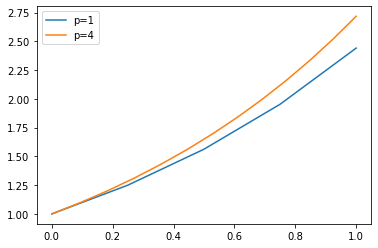

In [4]:
import odesolver as ode

ode.test_skalar()